In [11]:
# ===========================================
# 1. Configuración del Entorno
# ===========================================
!pip install --upgrade xgboost openpyxl joblib

import pandas as pd
import numpy as np

import os

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from joblib import Parallel, delayed, dump, load
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# ===========================================
# 2. Carga y Exploración de Datos
# ===========================================
df = pd.read_excel('Ejercicio Forecast.xlsx')
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(['codigoarticulo', 'fecha']).reset_index(drop=True)
print(df.head())
print(df.info())
print(df.describe())

# ===========================================
# 3. Definición de Funciones
# ===========================================

# Función para identificar y manejar valores atípicos
def handle_outliers(data, column):
    """
    Identifica valores atípicos usando el método IQR y crea una nueva columna sin ellos.
    Luego, imputa los valores eliminados mediante interpolación.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Crear una nueva columna con valores atípicos marcados como NaN
    #data[f'{column}1'] = data[column].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
    #-- Solo los atípicos superiores
    data[f'{column}1'] = data[column].apply(lambda x: x if  x <= upper_bound else np.nan)
    # Imputar valores NaN mediante interpolación
    data[f'{column}1'] = data[f'{column}1'].interpolate(method='linear')

    return data

# Función de creación de caracteristicas
def create_features(data, pandemia_start='2020-03-01', pandemia_end='2021-12-31', lags=[1,2,3]):
    df = data.copy()
    df['mes'] = df['fecha'].dt.month
    df['tendencia'] = np.arange(len(df))
    pandemia_start = pd.to_datetime(pandemia_start)
    pandemia_end = pd.to_datetime(pandemia_end)
    df['dummy_pandemia'] = ((df['fecha'] >= pandemia_start) & (df['fecha'] <= pandemia_end)).astype(int)

    #-- Variables Lag
    # for lag in lags:
    #     df[f'cantidad_lag_{lag}'] = df.groupby('codigoarticulo')['cantidad'].shift(lag)
    #df = df.dropna().reset_index(drop=True)

    #-- Variables potencia
    df['stock_cuadrado'] = df['stock'] ** 2
    df['margen_cuadrado'] = df['margen'] ** 2
    df['stock_cubo'] = df['stock'] ** 3
    df['margen_cubo'] = df['margen']**3
    df['stock_raiz'] = np.sqrt(df['stock'])
    df['margen_raiz'] = np.sqrt(df['margen'])

    #-- Variables logaritmicas
    df['stock_log'] = np.log(df['stock'] + 1)
    df['margen_log'] = np.log(df['margen'] + 1)

    df = pd.get_dummies(df, columns=['mes'], drop_first=True)
    return df

def check_and_create_missing_month_columns(df):
    """
    Verifica que el DataFrame tenga las columnas 'mes_1' a 'mes_12',
    y crea las que falten con valor False.

    Args:
        df (pd.DataFrame): El DataFrame a verificar.

    Returns:
        pd.DataFrame: El DataFrame con las columnas de mes completas.
    """
    mes_columns = [f'mes_{i}' for i in range(1, 13)]

    for mes_col in mes_columns:
        if mes_col not in df.columns:
            df[mes_col] = False  # Crea la columna con valor False
    return df


def guardar_mejor_modelo(modelo, codigoarticulo):
    """
    Guarda el modelo entrenado en un archivo .joblib en la carpeta modelos_guardados.
    """
    if not os.path.exists('modelos_guardados'):
        os.makedirs('modelos_guardados')

    path = f'modelos_guardados/modelo_{codigoarticulo}.joblib'
    dump(modelo, path)
    print(f'Modelo guardado: {path}')

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred)
    non_zero = denominator != 0
    return np.mean(2 * diff[non_zero] / denominator[non_zero]) * 100

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_val = smape(y_test, y_pred)
    return {'rmse': rmse, 'smape': smape_val, 'predictions': y_pred}

def process_articulo(articulo, data, features, target, preprocessor, tscv):
    df_art = data[data['codigoarticulo'] == articulo].copy().reset_index(drop=True)

    if len(df_art) < 25:
        return {'codigoarticulo': articulo, 'Mensaje': 'Datos insuficientes'}

    train_size = int(len(df_art) * 0.85)
    train_df, test_df = df_art.iloc[:train_size], df_art.iloc[train_size:]

    X_train_art, y_train_art = train_df[features], train_df[target]
    X_test_art, y_test_art = test_df[features], test_df[target]

    modelos = {
        'Regresión Lineal': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Ridge Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ]), {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Lasso Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', Lasso())
        ]), {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'ElasticNet Regression': GridSearchCV(Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', ElasticNet())
        ]), {'regressor__alpha': [0.01, 0.1, 1.0], 'regressor__l1_ratio': [0.2, 0.5, 0.8]}, cv=tscv, scoring='neg_root_mean_squared_error'),
        'Random Forest': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ]),
        'XGBoost': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
        ])
    }

    resultados_art = {'codigoarticulo': articulo}

    mejor_modelo = None
    mejor_rmse = float('inf')

    for nombre, modelo in modelos.items():
        try:
            if isinstance(modelo, GridSearchCV):
                modelo.fit(X_train_art, y_train_art)
                y_pred = modelo.predict(X_test_art)
            else:
                y_pred = evaluate_model(modelo, X_train_art, y_train_art, X_test_art, y_test_art)['predictions']

            rmse = np.sqrt(mean_squared_error(y_test_art, y_pred))
            smape_val = smape(y_test_art, y_pred)

            resultados_art[f'{nombre}_RMSE'] = rmse
            resultados_art[f'{nombre}_SMAPE'] = smape_val
            # Opcional: Almacenar las predicciones
            resultados_art[f'{nombre}_Predicciones'] = y_pred.tolist()


            if rmse < mejor_rmse:
                mejor_rmse = rmse
                mejor_modelo = modelo


        except Exception as e:
            resultados_art[f'{nombre}_Error'] = str(e)

    if mejor_modelo:
        guardar_mejor_modelo(mejor_modelo, articulo)

    return resultados_art

       fecha codigoarticulo  cantidad   stock  margen
0 2020-01-31     AUACSH1000      89.0   667.0   36.21
1 2020-02-29     AUACSH1000     143.0   522.0   36.11
2 2020-03-27     AUACSH1000     157.0   360.0   37.10
3 2020-04-30     AUACSH1000      12.0  1148.0   40.71
4 2020-05-29     AUACSH1000      70.0  1077.0   47.95
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           443 non-null    datetime64[ns]
 1   codigoarticulo  443 non-null    object        
 2   cantidad        443 non-null    float64       
 3   stock           443 non-null    float64       
 4   margen          442 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 17.4+ KB
None
                               fecha     cantidad         stock       margen
count                            443   443.000000    4

In [12]:

# Ordenar los datos por 'codigoarticulo' y 'fecha'
df = df.sort_values(['codigoarticulo', 'fecha']).reset_index(drop=True)

# Aplicar la función de manejo de valores atípicos para cada codigoarticulo
df_cleaned = df.groupby('codigoarticulo').apply(lambda group: handle_outliers(group, 'cantidad'))


# Eliminar el índice adicional creado por groupby.apply
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.sort_values(['codigoarticulo', 'fecha'], inplace=True)
df_cleaned['cantidad1'] = df_cleaned['cantidad1'].interpolate(method='backfill')
df_cleaned['margen'] = df_cleaned['margen'].interpolate(method='backfill')
df_cleaned.info()

# Crear las características
df_feat = create_features(df_cleaned)
print(df_feat.head())

# Definir las características y la variable objetivo
features = [
    'stock',
    'margen',
    'tendencia',
    'dummy_pandemia',
    # 'cantidad_lag_1',
    # 'cantidad_lag_2',
    # 'cantidad_lag_3'
] + [col for col in df_feat.columns if 'mes_' in col]

target = 'cantidad1'

# Definir el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ]
)

# Definir TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# Obtener todos los códigos de artículo únicos
articulos = df_feat['codigoarticulo'].unique()

# Procesar en paralelo
resultados_finales = Parallel(n_jobs=-1)(
    delayed(process_articulo)(articulo, df_feat, features, target, preprocessor, tscv)
    for articulo in articulos
)

# Convertir los resultados a un DataFrame
df_resultados_finales = pd.DataFrame(resultados_finales)
print(df_resultados_finales.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           443 non-null    datetime64[ns]
 1   codigoarticulo  443 non-null    object        
 2   cantidad        443 non-null    float64       
 3   stock           443 non-null    float64       
 4   margen          443 non-null    float64       
 5   cantidad1       443 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 20.9+ KB
       fecha codigoarticulo  cantidad   stock  margen  cantidad1  tendencia  \
0 2020-01-31     AUACSH1000      89.0   667.0   36.21       89.0          0   
1 2020-02-29     AUACSH1000     143.0   522.0   36.11      143.0          1   
2 2020-03-27     AUACSH1000     157.0   360.0   37.10      157.0          2   
3 2020-04-30     AUACSH1000      12.0  1148.0   40.71       12.0          3   
4 2020-05-29 

In [13]:
#-- Almacenamiento de las metricas de desempeño en los diferentes modelos
df_resultados_finales.to_excel('resultados_finales.xlsx', index=False)

In [29]:
# Seleccionar un artículo para visualizar
#--- 'AUACSH1000' 'HEELAG1141' 'HEELPW1565' 'HEELXIW20'
articulo_ejemplo =  'HEFUFG71'  # Reemplaza con un código

def plot_modelos_articulos(articulo_ejemplo):
  # Filtrar los resultados para el artículo seleccionado
  resultado_articulo = df_resultados_finales[df_resultados_finales['codigoarticulo'] == articulo_ejemplo]

  # Verificar si hay predicciones disponibles
  modelos_disponibles = ['Regresión Lineal', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 'Random Forest', 'XGBoost']
  predicciones = {}
  for modelo in modelos_disponibles:
      pred_col = f'{modelo}_Predicciones'
      if pred_col in resultado_articulo.columns:
          predicciones[modelo] = resultado_articulo.iloc[0][pred_col]

  # Verificar que haya al menos un modelo con predicciones
  if not predicciones:
      print(f"No hay predicciones disponibles para el artículo {articulo_ejemplo}.")
  else:
      # Obtener los datos reales
      df_art_ejemplo = df_feat[df_feat['codigoarticulo'] == articulo_ejemplo].copy().reset_index(drop=True)
      train_size_art = int(len(df_art_ejemplo) * 0.85)
      test_df_art = df_art_ejemplo.iloc[train_size_art:].copy()
      y_true = test_df_art[target].values

      # Crear DataFrame para visualizar las predicciones de diferentes modelos
      df_plot = pd.DataFrame({
          'fecha': test_df_art['fecha'],
          'Real': y_true
      })

      for modelo, preds in predicciones.items():
          df_plot[modelo] = preds

      # Graficar todas las predicciones
      plt.figure(figsize=(14,8))
      plt.plot(df_plot['fecha'], df_plot['Real'], label='Real', marker='o')

      for modelo in modelos_disponibles:
          if modelo in predicciones:
              plt.plot(df_plot['fecha'], df_plot[modelo], label=f'Predicción {modelo}', marker='x')

      plt.xlabel('Fecha')
      plt.ylabel('Cantidad')
      plt.title(f'Pronóstico de Cantidad para {articulo_ejemplo}')
      plt.legend()
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()

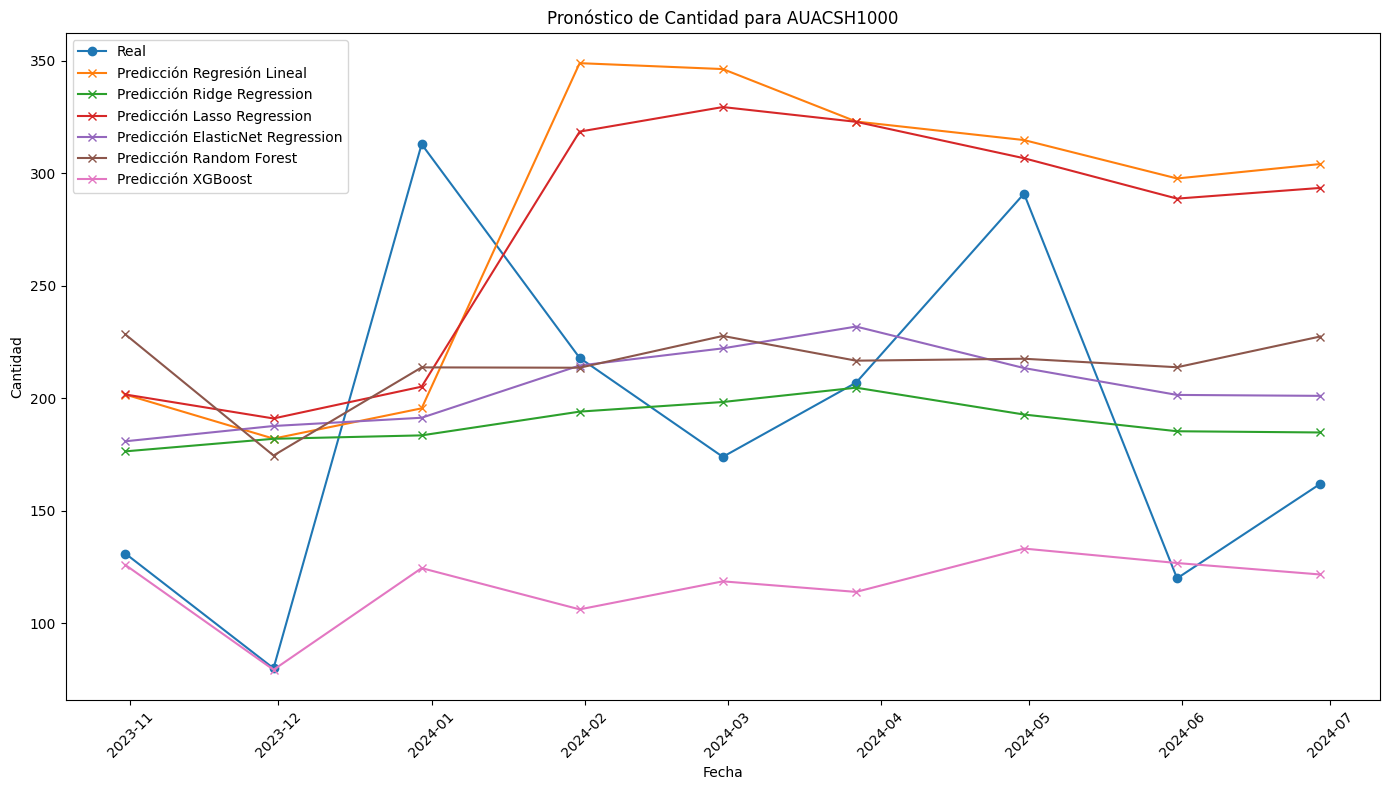

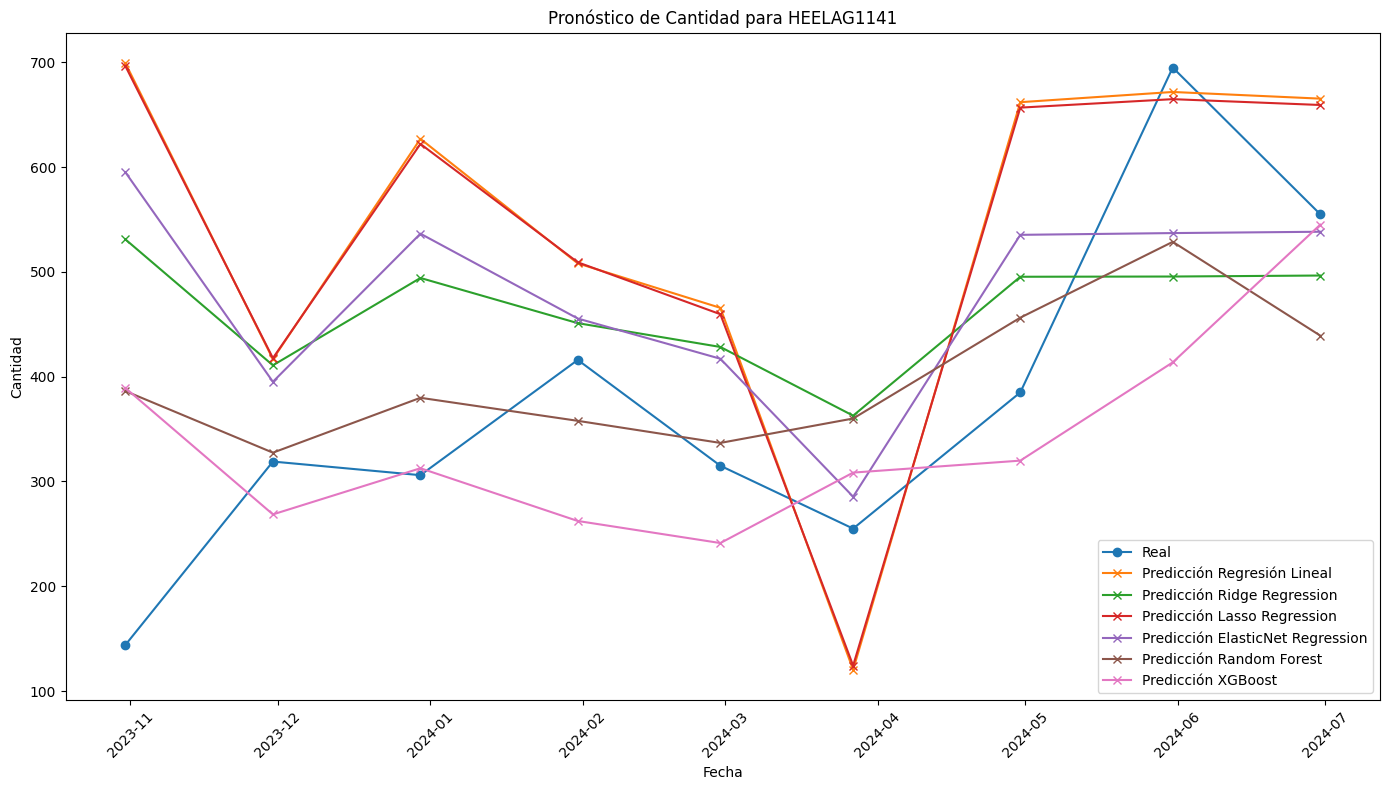

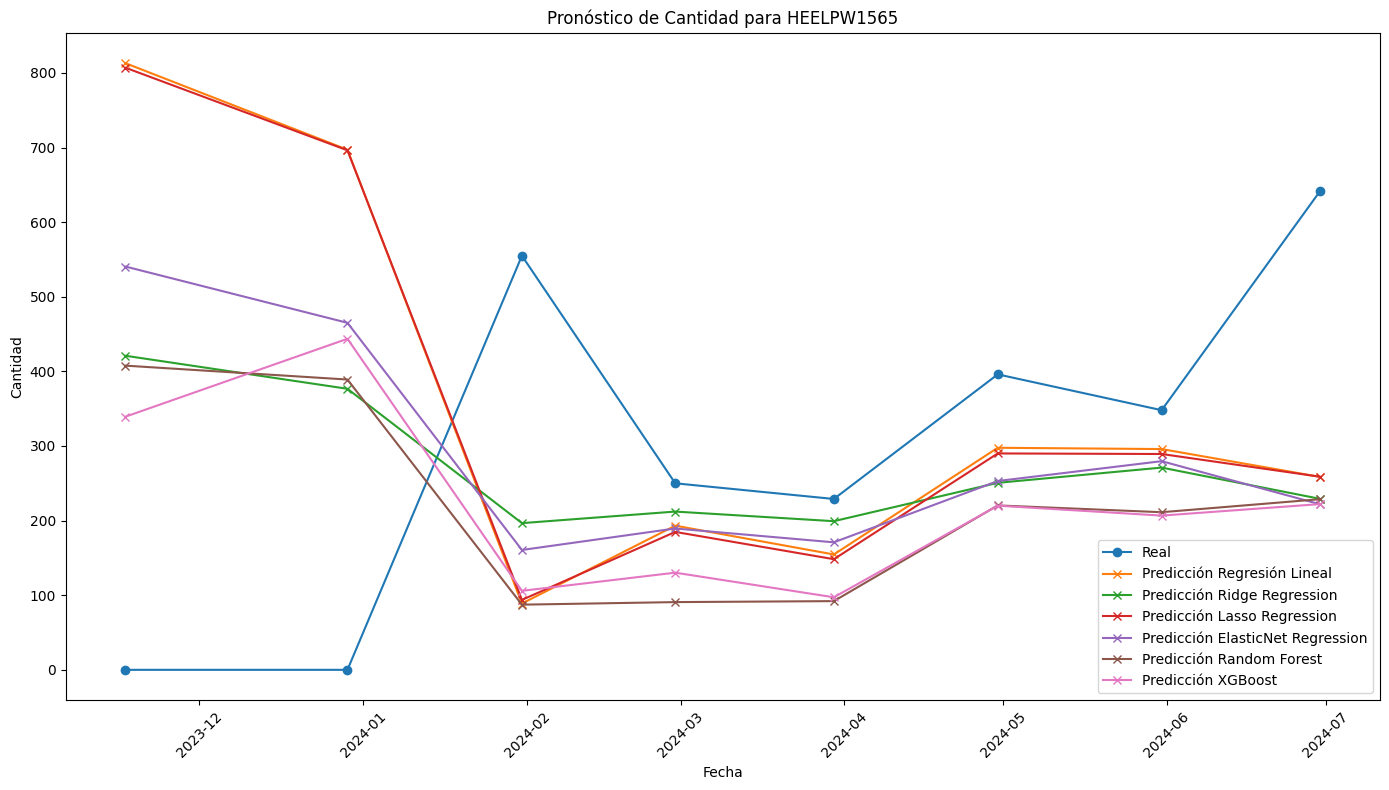

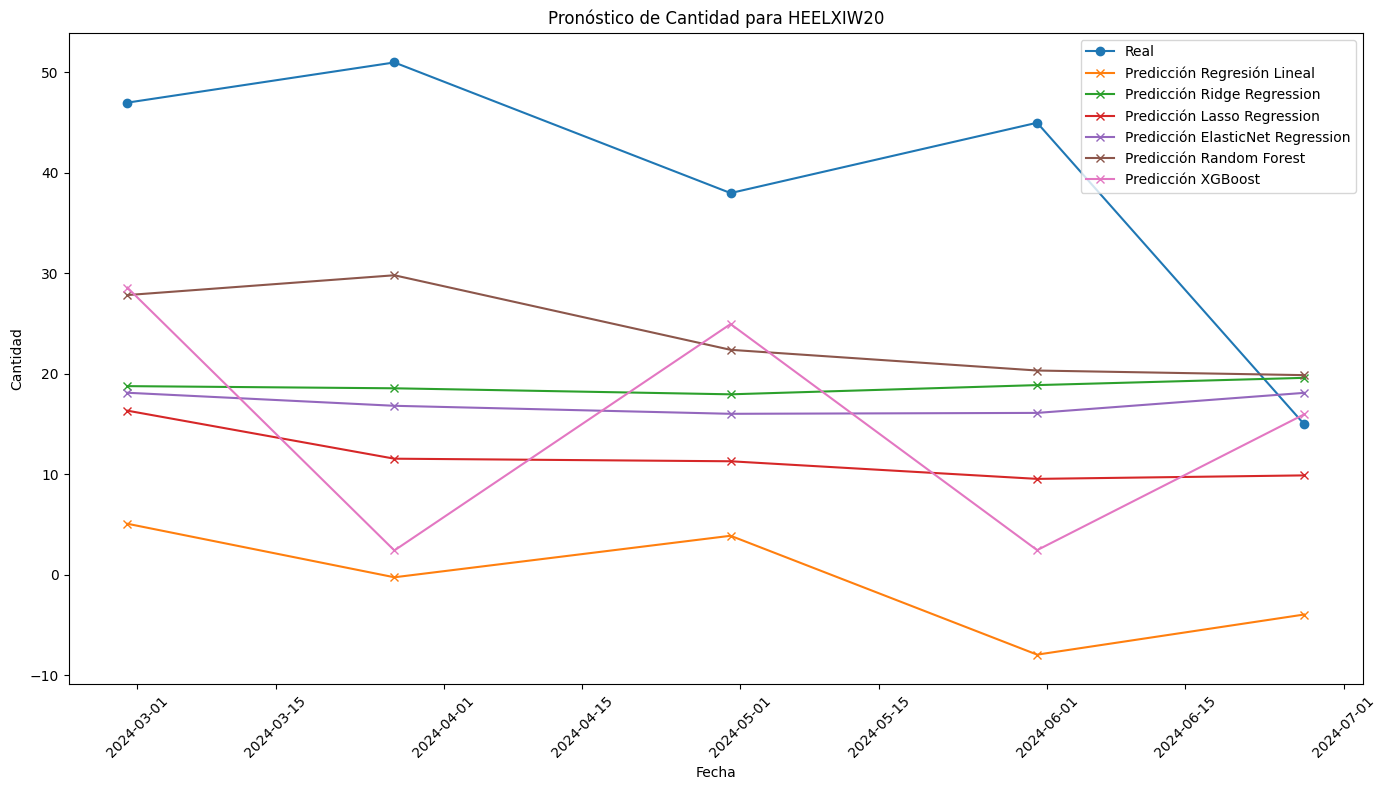

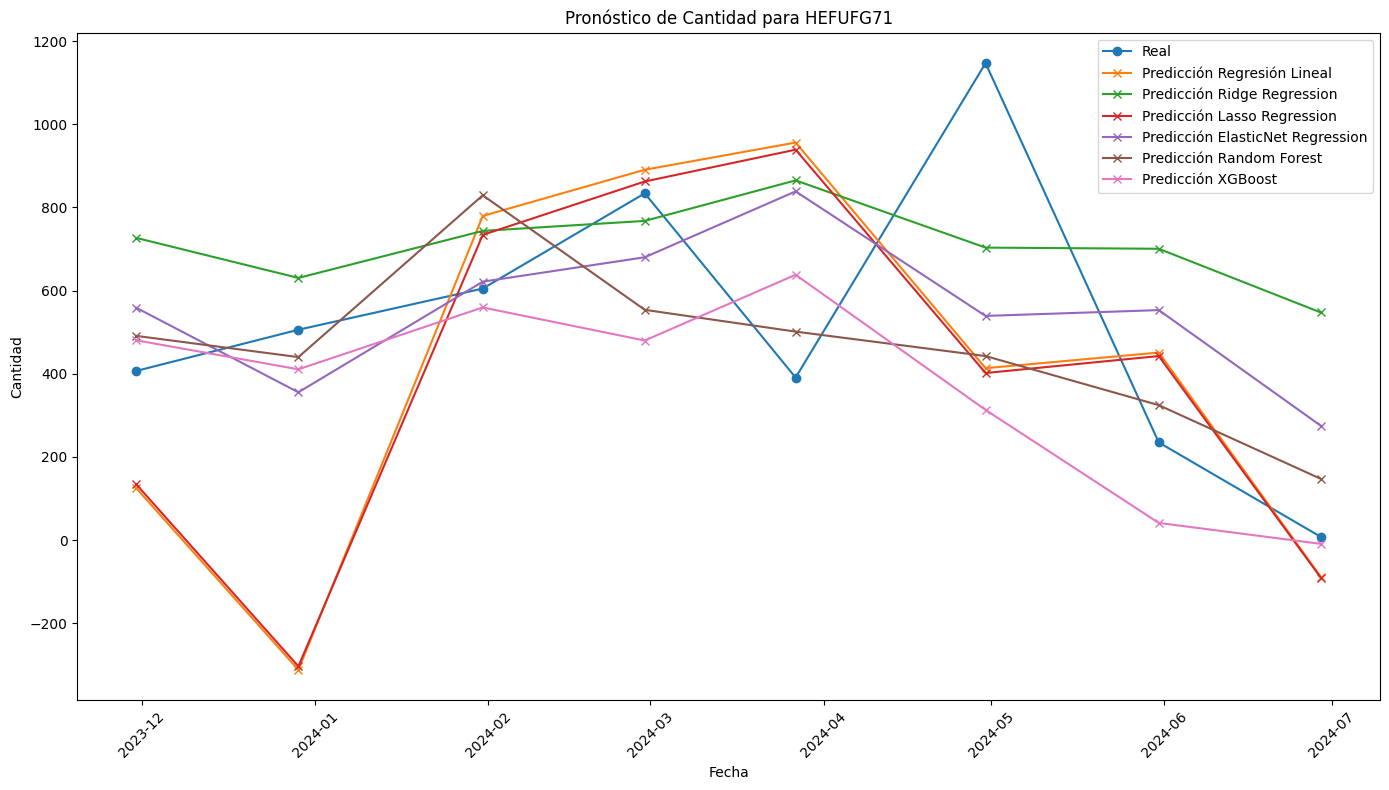

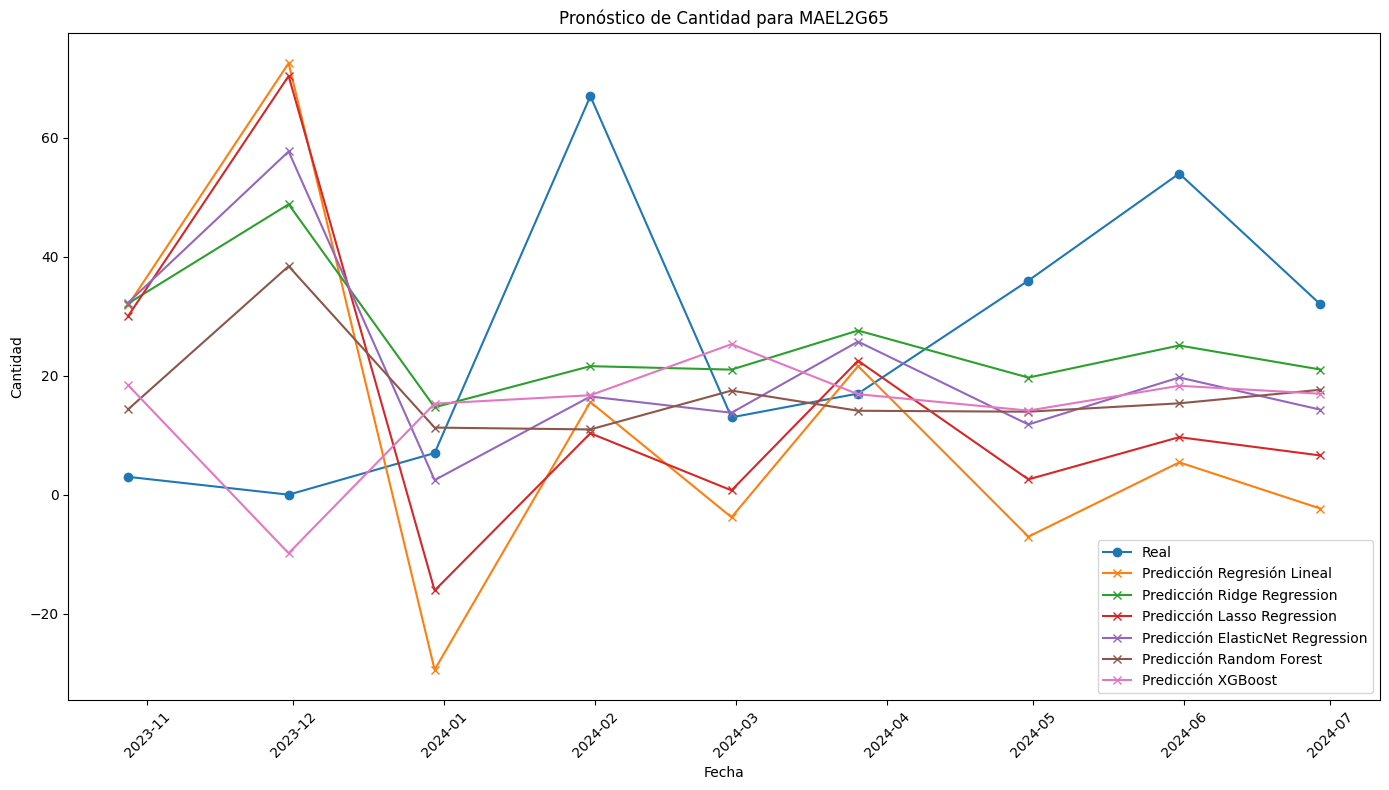

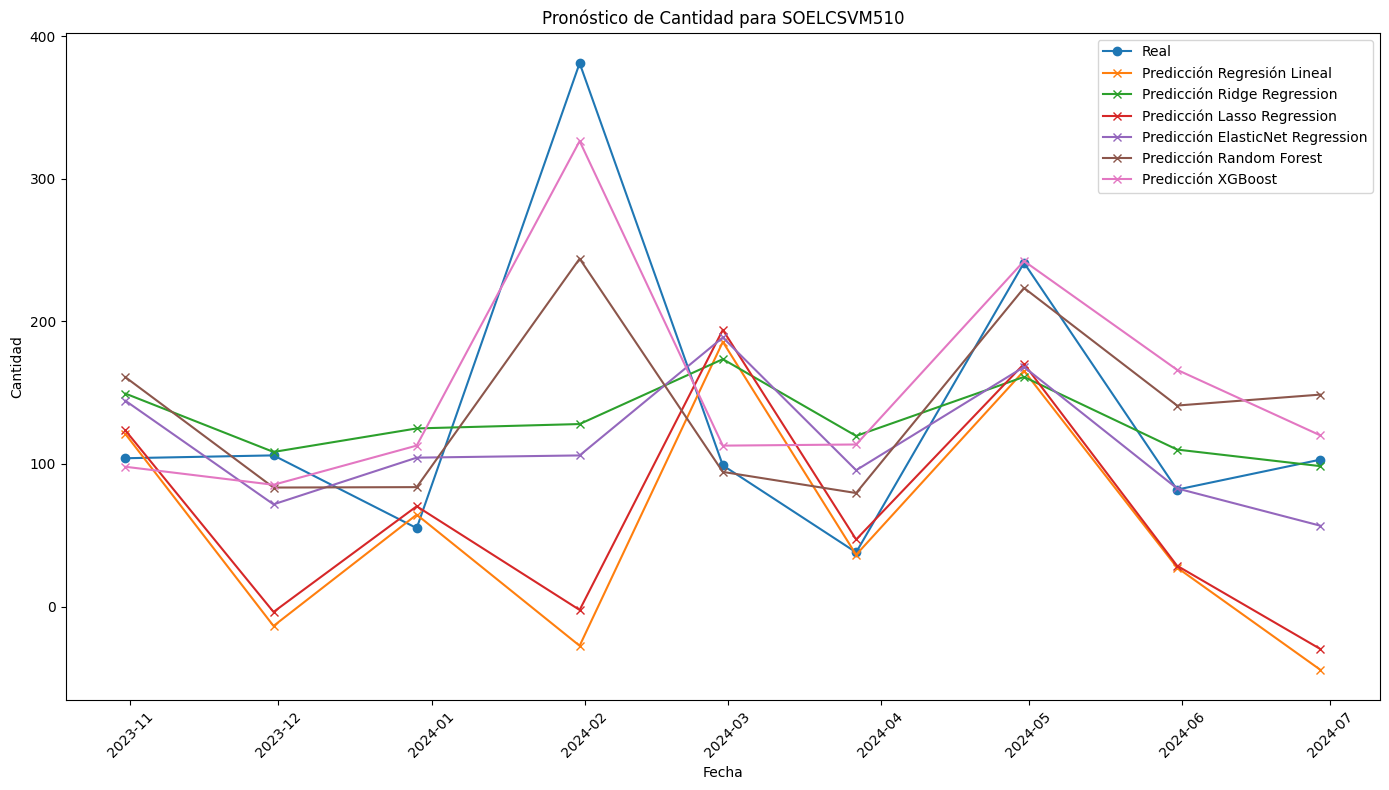

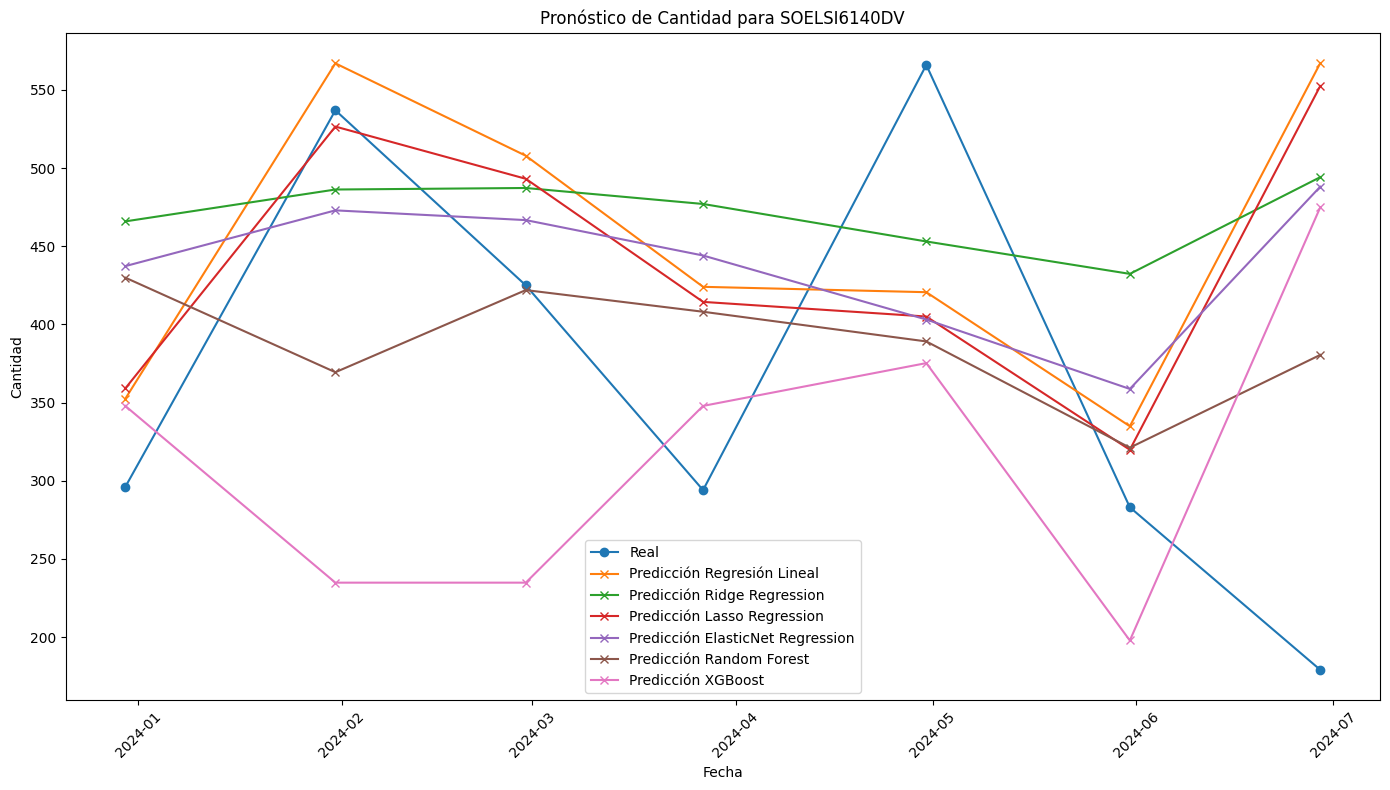

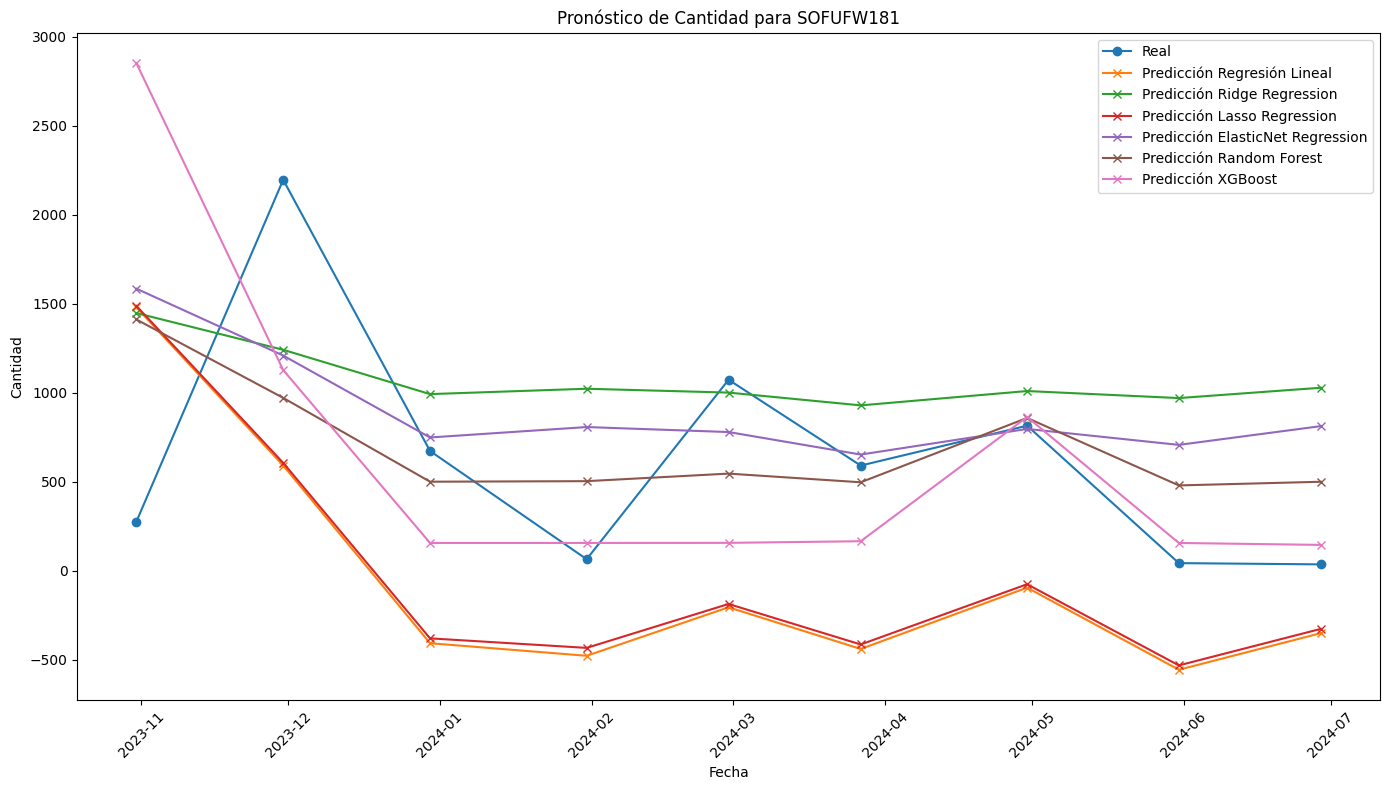

In [30]:
# Obtener la lista de artículos únicos
articulos = df_resultados_finales['codigoarticulo'].unique()

# Iterar sobre la lista de artículos y llamar a la función para cada uno
for articulo_ in articulos:
    plot_modelos_articulos(articulo_)

In [15]:
def cargar_modelo_y_predecir(codigoarticulo, X_nuevo):
    """
    Carga el modelo guardado y predice para nuevos valores de X.
    """
    path = f'modelos_guardados/modelo_{codigoarticulo}.joblib'
    if not os.path.exists(path):
        raise FileNotFoundError(f'No se encontró un modelo guardado para el código de artículo {codigoarticulo}')

    modelo = load(path)
    return modelo.predict(X_nuevo)

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def pronosticar_variables_exog(articulo, data, k):
    """
    Pronostica k meses hacia adelante las variables stock y margen utilizando modelos de series de tiempo univariantes.
    """
    df_art = data[data['codigoarticulo'] == articulo].copy().reset_index(drop=True)
    resultados = {'codigoarticulo': articulo}

    for variable in ['stock', 'margen']:
        if df_art[variable].isna().sum() > 0:
            df_art[variable].fillna(method='ffill', inplace=True)

        modelo = ExponentialSmoothing(df_art[variable], trend='add', seasonal='add', seasonal_periods=12).fit()
        predicciones = modelo.forecast(k)
        predicciones = np.where(predicciones < 0, 0, predicciones)
        predicciones = np.round(predicciones).astype(int)
        resultados[f'{variable}_pronostico'] = predicciones.tolist()

    return resultados

In [17]:
# prompt: Toma el Dataframe df y pronostica los próximos 6 meses por cada articulo de las variables margen y stock usando la función pronosticar_variables_exog y también agrega una columna de tiempo que indique la fecha a la que hace referencia el pronóstico

# Obtener todos los códigos de artículo únicos
articulos = df_feat['codigoarticulo'].unique()

# Número de meses a pronosticar
k = 6

# Procesar en paralelo para cada artículo
resultados_pronostico = Parallel(n_jobs=-1)(
    delayed(pronosticar_variables_exog)(articulo, df_feat, k) for articulo in articulos
)

# Convertir los resultados a un DataFrame
df_pronostico = pd.DataFrame(resultados_pronostico)

# Crear un DataFrame para almacenar los pronósticos con fechas
pronosticos_con_fechas = []

for index, row in df_pronostico.iterrows():
  codigo_articulo = row['codigoarticulo']
  ultima_fecha = df_feat[df_feat['codigoarticulo'] == codigo_articulo]['fecha'].max()
  fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1), periods=k, freq='MS')

  for i in range(k):
    pronosticos_con_fechas.append({
        'codigoarticulo': codigo_articulo,
        'fecha': fechas_futuras[i],
        'stock_pronostico': row['stock_pronostico'][i],
        'margen_pronostico': row['margen_pronostico'][i]
    })

df_pronostico_fechas = pd.DataFrame(pronosticos_con_fechas)

# Mostrar el DataFrame con los pronósticos y las fechas
print(df_pronostico_fechas.head())


  codigoarticulo      fecha  stock_pronostico  margen_pronostico
0     AUACSH1000 2024-08-01               938                 30
1     AUACSH1000 2024-09-01               640                 29
2     AUACSH1000 2024-10-01               457                 29
3     AUACSH1000 2024-11-01               271                 28
4     AUACSH1000 2024-12-01               295                 26


In [28]:
df_pronostico_fechas.sample(5)

,codigoarticulo,fecha,stock,margen
45,SOELSI6140DV,2024-11-01,0,55
11,HEELAG1141,2025-01-01,0,51
25,HEFUFG71,2024-09-01,0,51
2,AUACSH1000,2024-10-01,457,29
6,HEELAG1141,2024-08-01,0,45


In [21]:
#-- Creando las variables necesarias para los pronósticos
df_pronostico_fechas.rename(columns={'stock_pronostico': 'stock', 'margen_pronostico': 'margen'}, inplace=True)
df_features_tmp = create_features(df_pronostico_fechas)
df_features_pronostico = check_and_create_missing_month_columns(df_features_tmp)
df_features_pronostico

,codigoarticulo,fecha,stock,margen,tendencia,dummy_pandemia,stock_cuadrado,margen_cuadrado,stock_cubo,margen_cubo,...,mes_10,mes_11,mes_12,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7
0,AUACSH1000,2024-08-01,938,30,0,0,879844,900,825293672,27000,...,False,False,False,False,False,False,False,False,False,False
1,AUACSH1000,2024-09-01,640,29,1,0,409600,841,262144000,24389,...,False,False,False,False,False,False,False,False,False,False
2,AUACSH1000,2024-10-01,457,29,2,0,208849,841,95443993,24389,...,True,False,False,False,False,False,False,False,False,False
3,AUACSH1000,2024-11-01,271,28,3,0,73441,784,19902511,21952,...,False,True,False,False,False,False,False,False,False,False
4,AUACSH1000,2024-12-01,295,26,4,0,87025,676,25672375,17576,...,False,False,True,False,False,False,False,False,False,False
5,AUACSH1000,2025-01-01,394,25,5,0,155236,625,61162984,15625,...,False,False,False,False,False,False,False,False,False,False
6,HEELAG1141,2024-08-01,0,45,6,0,0,2025,0,91125,...,False,False,False,False,False,False,False,False,False,False
7,HEELAG1141,2024-09-01,0,51,7,0,0,2601,0,132651,...,False,False,False,False,False,False,False,False,False,False
8,HEELAG1141,2024-10-01,0,53,8,0,0,2809,0,148877,...,True,False,False,False,False,False,False,False,False,False
9,HEELAG1141,2024-11-01,0,51,9,0,0,2601,0,132651,...,False,True,False,False,False,False,False,False,False,False


In [22]:
# prompt: Toma el dataframe  df_features_pronostico como el archivo base para usar la función cargar_modelo_y_predecir para predecir por cada codigoarticulo

# Crear un DataFrame vacío para almacenar los pronósticos
pronosticos = []

# Iterar sobre cada código de artículo
for codigo in df_features_pronostico['codigoarticulo'].unique():
    # Filtrar el DataFrame para el código de artículo actual
    df_temp = df_features_pronostico[df_features_pronostico['codigoarticulo'] == codigo].copy()

    # Crear las características necesarias para la predicción
    X_nuevo = df_temp[features]

    # Cargar el modelo y predecir
    try:
        predicciones = cargar_modelo_y_predecir(codigo, X_nuevo)

        # Agregar los pronósticos al DataFrame
        for i in range(len(predicciones)):
            pronosticos.append({
                'codigoarticulo': codigo,
                'fecha': df_temp['fecha'].iloc[i],
                'cantidad_pronostico': predicciones[i]
            })
    except FileNotFoundError as e:
        print(e)  # Imprime el error si no se encuentra el modelo

# Convertir la lista de pronósticos en un DataFrame
df_pronosticos = pd.DataFrame(pronosticos)
df_pronosticos['cantidad_pronostico'] = np.where(df_pronosticos['cantidad_pronostico'] < 0, 0, df_pronosticos['cantidad_pronostico'])
df_pronosticos['cantidad_pronostico'] = df_pronosticos['cantidad_pronostico'].round().astype(int)
# Mostrar el DataFrame con los pronósticos
df_pronosticos.head(7)


,codigoarticulo,fecha,cantidad_pronostico
0,AUACSH1000,2024-08-01,187
1,AUACSH1000,2024-09-01,158
2,AUACSH1000,2024-10-01,163
3,AUACSH1000,2024-11-01,172
4,AUACSH1000,2024-12-01,172
5,AUACSH1000,2025-01-01,179
6,HEELAG1141,2024-08-01,42
7,HEELAG1141,2024-09-01,57
8,HEELAG1141,2024-10-01,113
9,HEELAG1141,2024-11-01,29


In [24]:
#-- Guardar datos pronósticados
df_pronosticos.to_excel('pronosticos_articulos.xlsx', index=False)

In [25]:
# prompt: hacer una función para gráficar los valores de cantidad en el DataFrame df_feat y la variable cantidad_pronostico en el Dataframe  df_pronosticos para cada articulo

def plot_cantidad_vs_pronostico(articulo):
    """
    Grafica los valores de cantidad en df_feat y cantidad_pronostico en df_pronosticos para un artículo dado.
    """
    # Filtrar los DataFrames para el artículo específico
    df_feat_articulo = df_feat[df_feat['codigoarticulo'] == articulo]
    df_pronosticos_articulo = df_pronosticos[df_pronosticos['codigoarticulo'] == articulo]

    # Crear el gráfico
    plt.figure(figsize=(14, 6))
    plt.plot(df_feat_articulo['fecha'], df_feat_articulo['cantidad1'], label='Cantidad Real')
    plt.plot(df_pronosticos_articulo['fecha'], df_pronosticos_articulo['cantidad_pronostico'], label='Cantidad Pronosticada')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.title(f'Cantidad vs. Pronóstico para Artículo {articulo}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


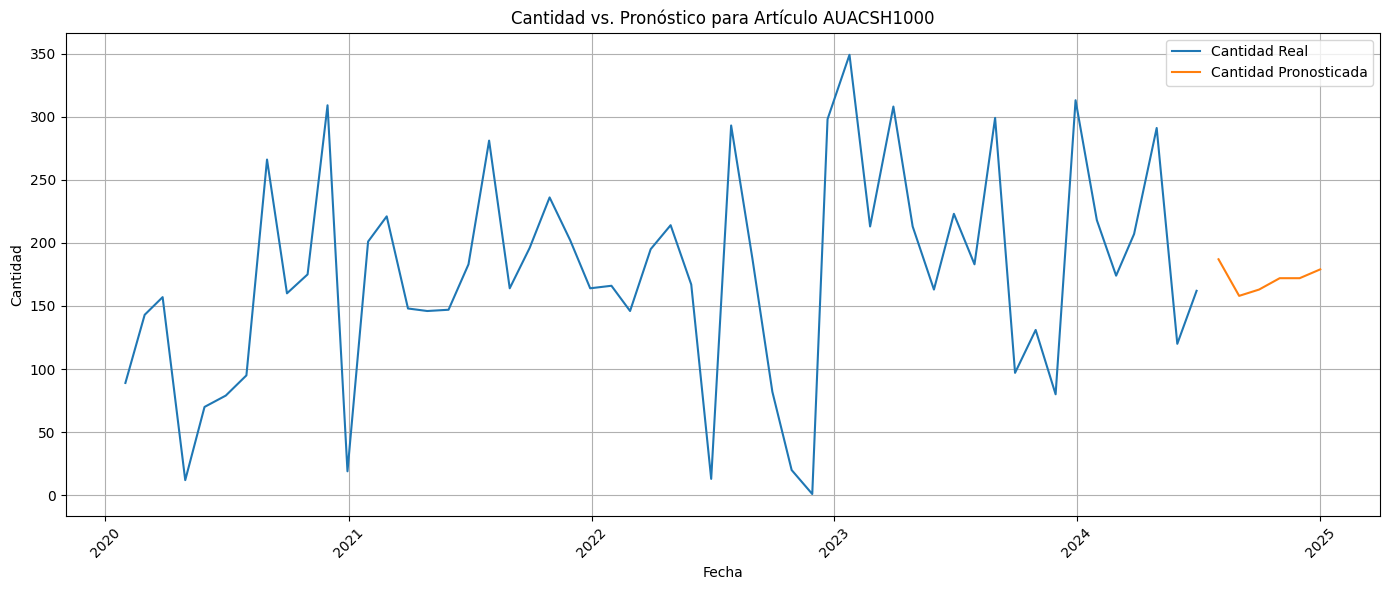

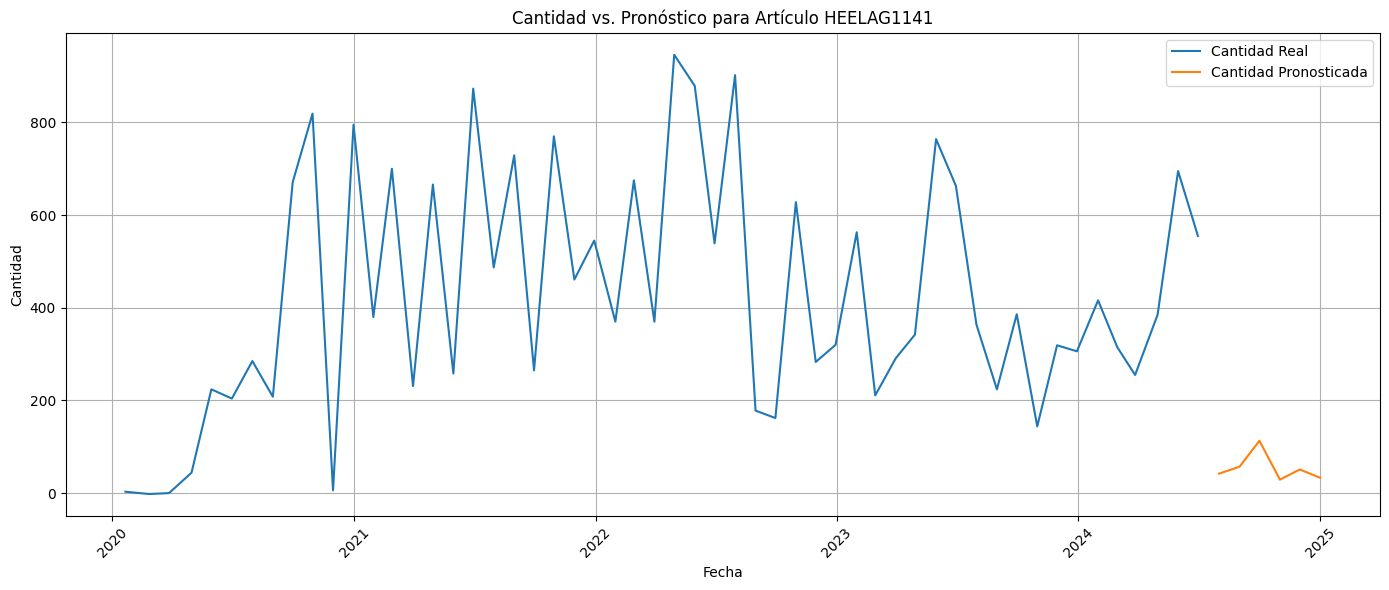

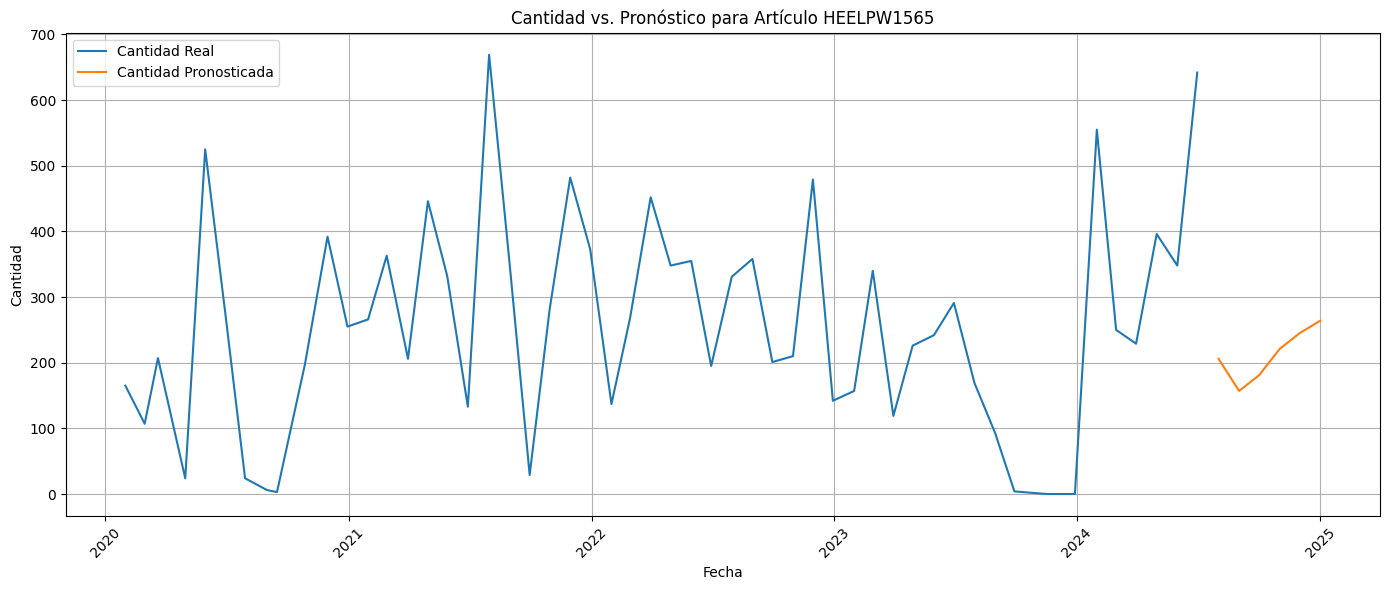

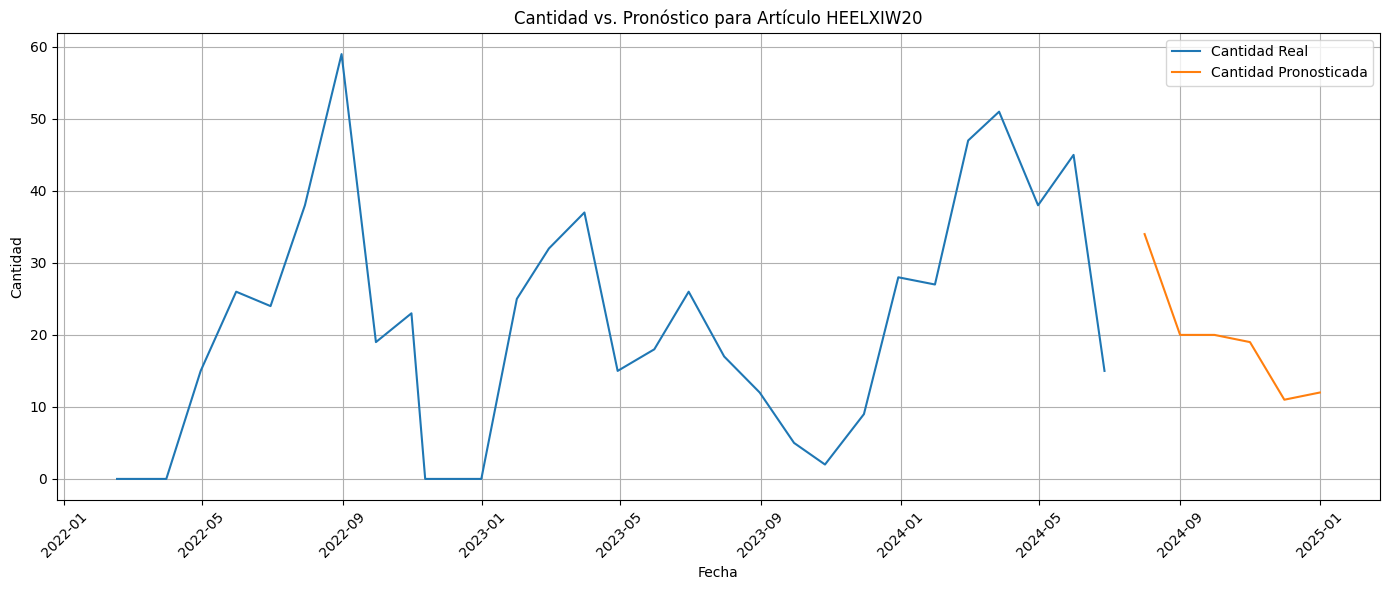

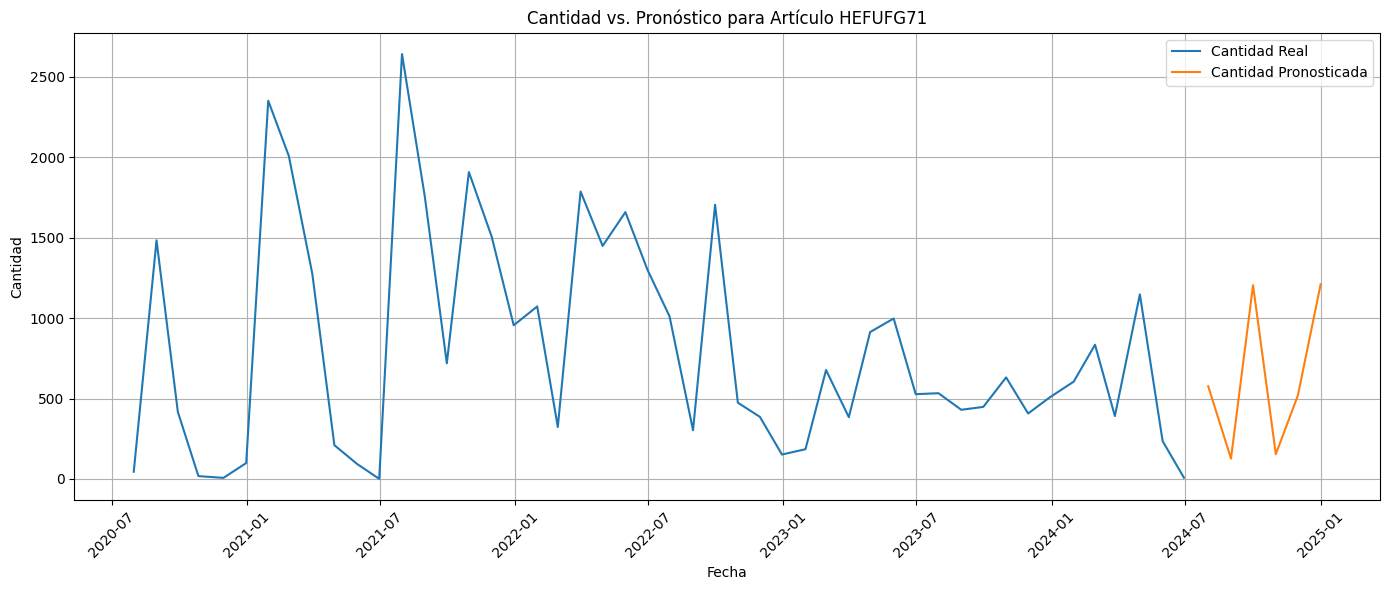

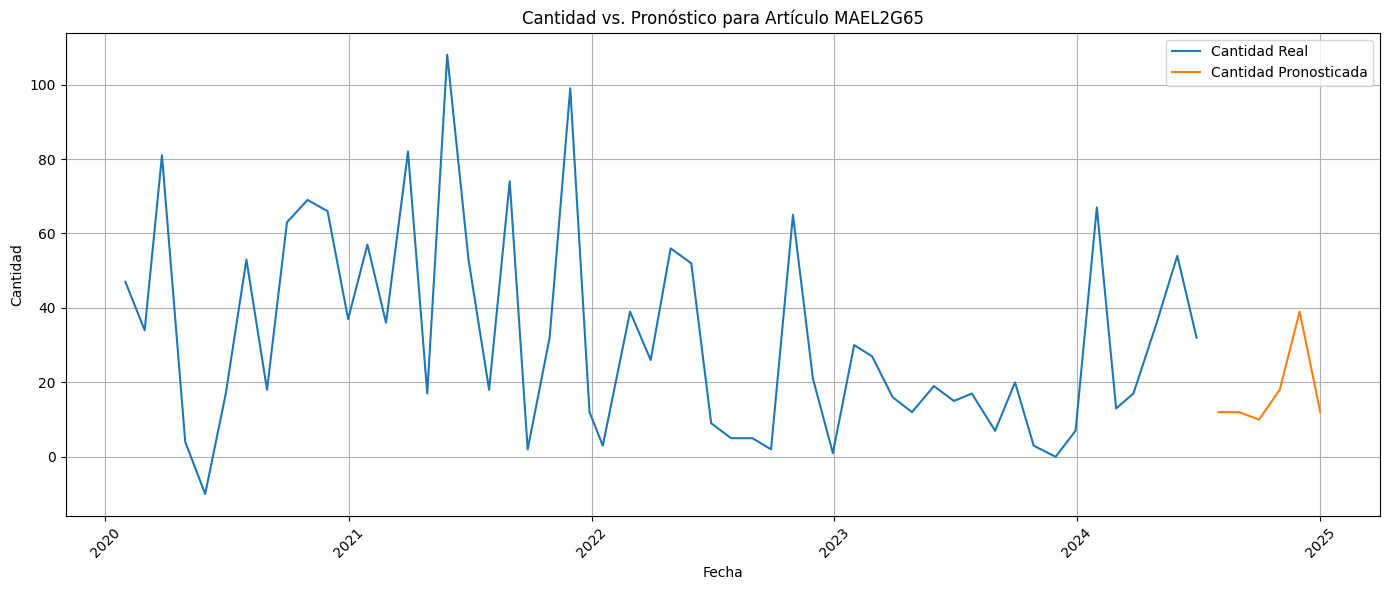

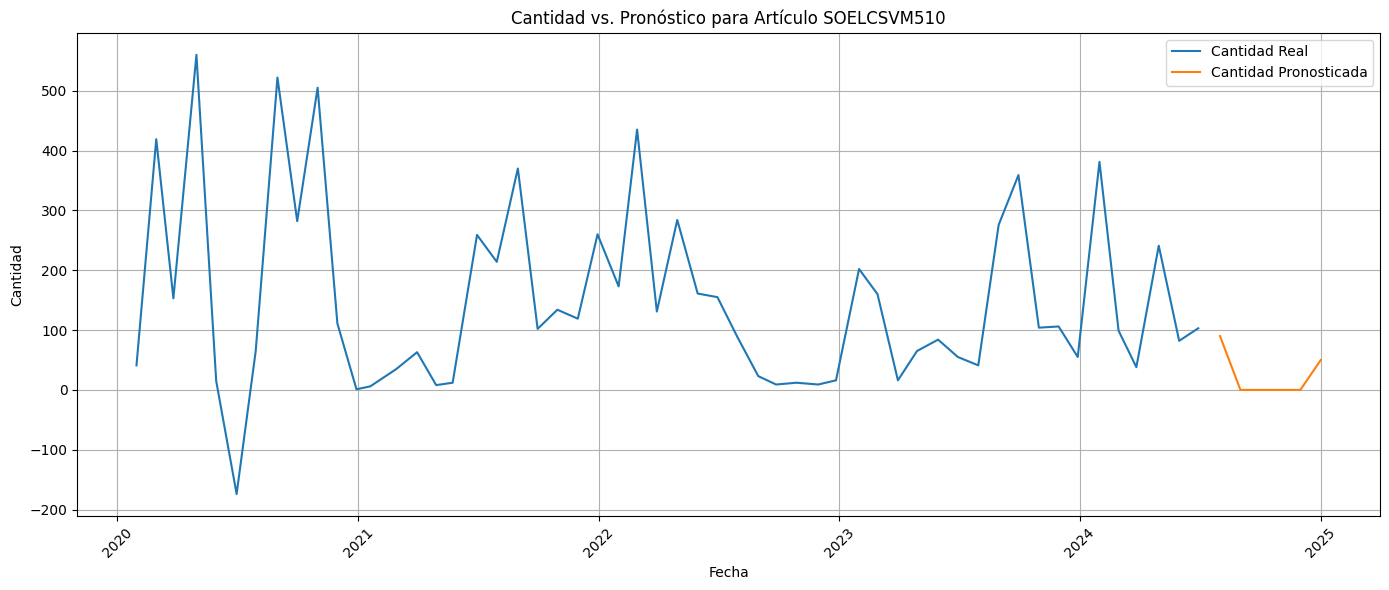

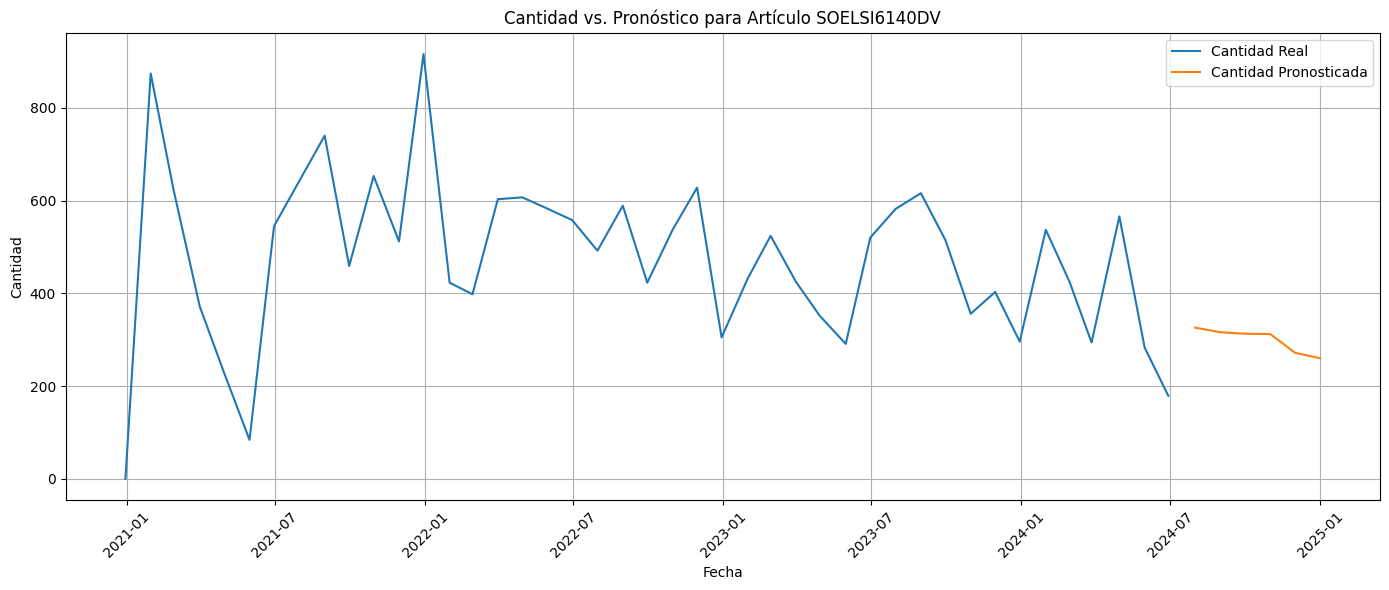

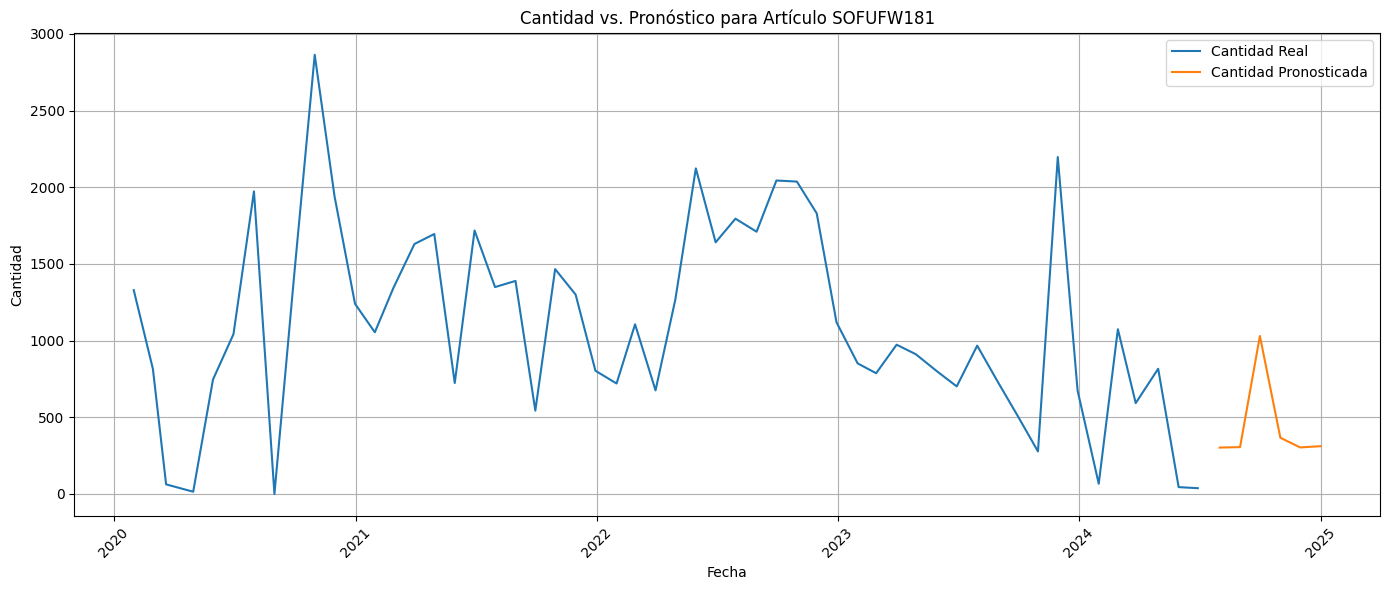

In [27]:
# Obtener la lista de artículos únicos
articulos = df_pronosticos['codigoarticulo'].unique()

# Iterar sobre la lista de artículos y llamar a la función para cada uno
for articulo in articulos:
    plot_cantidad_vs_pronostico(articulo)


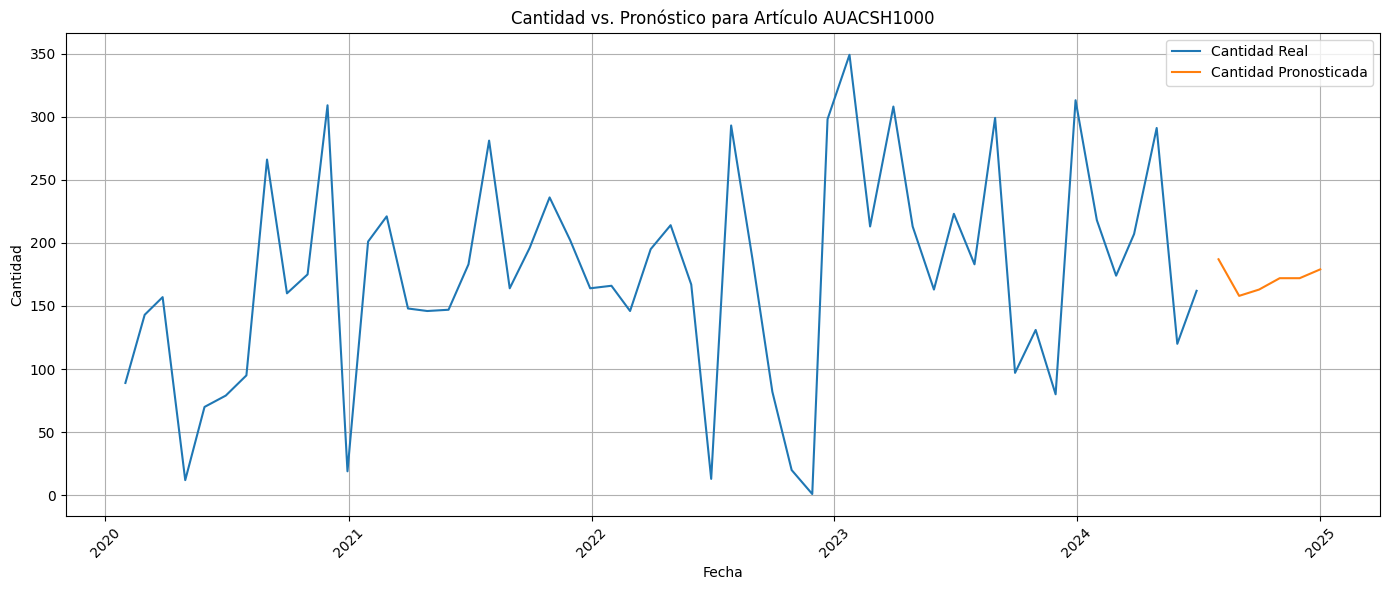

In [26]:
plot_cantidad_vs_pronostico(articulo = 'AUACSH1000')